In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
import researchpy as rp
from scipy import stats
%matplotlib inline
%run '/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/src/EDA_hypothesis_functions.py'


In [134]:
#read csv file into Pandas DataFrame
df = pd.read_csv('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/data/diabetic_data.csv')

## Introduction
With estimated costs in the order of tens of billions per annum, hospital readmissions impose a significant financial burden on health care institutions across the nation. Up until more recent times, there was not a lot of incentive for Hospitals to reduce these readmissions. When Center for Medicares and Medicaid Services began public reporting hospital readmission rates, the ethical and professional incentive was there, but hospitals that aimed to reduce readmissions were losing revenue unless they could fill their beds. Enter the Hospital Readmissions Reduction Program (HRRP) circa 2013 which provided financial incentive for Hospitals to reduce readmissions. 

This has still proven to be a difficult task but hospitals are employing a number of strategies to reduce the preventable readmissions. Progress has been made since the implementation of the HRRP but estimates of readmissions that could have been prevented are still as high as 70%. It is therefore in their best interest to find ways to further reduce this undesirable outcome. 

## Strategy

- Data Preprocessing
- Exploratory Data Analysis
- Hypothesis Testing

## Data Overview

The data set was made available by Virginia Commonwealth University via the UCI Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

- It contains 101766 observations with 50 different features. 
- Features are largely categorical variables

## Data Preprocessing

The metric of interest that labels whether a patient was readmitted or not has three possible values: 

- **<30** : Patients that were readmitted in less than thirty days. 
- **>30** : Patients that were readmitted in greater than thirty days. 
- **NO** : Patients that were not readmitted

The metric of concern according to the HRRP is patients that were readmitted in less than thirty days. Therefore we will rename the column to 'readmitted_<30d' and combine the '>30' and 'NO'.  

In [19]:
%cd galvanize/capstones/Predicting_Hospital_Readmissions
%pwd

/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions


'/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions'

In [135]:
df = df.rename(columns={'readmitted':'readmit'})

In [136]:
# finding frequency of patients readmitted in less than 30 days. 
df['readmit'].replace({'>30': 'False', 'NO': 'False',
                               '<30': 'True'}, inplace=True)
readmitcounts = pd.DataFrame(df.groupby(df['readmit']).size())
readmitcounts = readmitcounts.reset_index()
readmitcounts.columns = ['readmit', 'frequency']
readmitcounts


,readmit,frequency
0,False,90409
1,True,11357


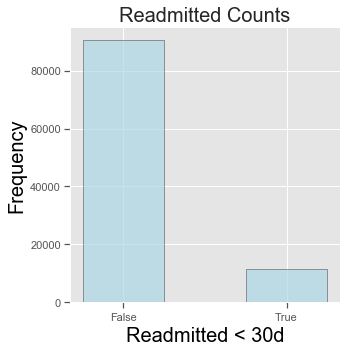

In [137]:
fig,ax = plt.subplots(1, figsize=(5,5))
ax.bar(readmitcounts['readmit'], readmitcounts.frequency,
       color='lightblue',width=0.5,alpha=0.7, edgecolor='black')
ax.set_ylabel('Frequency',fontsize=20,color='black')
# ax.set_xticks(size=24)
# ax.set_yticks(color='black')
ax.set_xlabel('Readmitted < 30d',fontsize=20,color='black')
ax.set_title('Readmitted Counts',fontsize=20)
plt.tight_layout()
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/target.png')

The take-away from the bar chart above is that we are working with a very imbalanced data set. This will need to be take into consideration when we start working on the predictive model.  

Taking a cursory glance at the data showed that a '?' was used where values were unknown. To address this, we will replace all '?' with np.nan. This will paint a more honest picture of any missing values. 


In [138]:
df = df.replace('?',np.nan)

In [139]:
missing_data(df,5)

["Column 'weight' is missing 96.86% of data",
 "Column 'payer_code' is missing 39.56% of data",
 "Column 'medical_specialty' is missing 49.08% of data"]

In [140]:
missing_data(df.replace('None', np.nan),5)

["Column 'weight' is missing 96.86% of data",
 "Column 'payer_code' is missing 39.56% of data",
 "Column 'medical_specialty' is missing 49.08% of data",
 "Column 'max_glu_serum' is missing 94.75% of data",
 "Column 'A1Cresult' is missing 83.28% of data"]

**What do we do with the columns containing missing data?**

- Since weight is missing ~97% of data, we will drop the column. It would have been a nice feature to evaluate. 
- Additionally, payer_code and medical_specialty are missing ~40 and ~50 % of data respectively. Although there are other ways to deal with this, we will remove the columns. 

In [141]:
df.drop(['weight','payer_code','medical_specialty'], axis=1, inplace=True)


A good next step would be to evaluate the unique values that each feature contains. If the feature contains a large amount of values (i.e. Patient ID, encounter ID) we will just take a count of the unique values in the column. 

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101745 non-null object
diag_2                      101408 non-null object
diag_3                      100343 

In [143]:
# iterate through all columns and extract the unique values in each column
for col in df.columns:
    colstr = str(col)
    vals = df[colstr].unique()
    
    if len(vals) < 35:
        print(colstr)
        print(vals)
    else:
        print(colstr +': '+str(len(vals))+' unique values')

encounter_id: 101766 unique values
patient_nbr: 71518 unique values
race
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency
[ 0  1  2  4  3  9  5  7  6  8 22 25 10 13 42 16 11 28 15 14 18 12 21 20
 19 46 76 37 64 63 54 24 29]
number_inpatient
[ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 17 16 21 18 19]
diag_1: 717 unique values
diag_2: 749 unique values
diag_3: 790 unique values
number_diagnoses
[ 1

Since 'examide' and 'citoglipton' only contain one unique value, we will drop these two features from the data frame. 

In [144]:
df.drop(['citoglipton', 'examide'], axis=1, inplace=True)

In [145]:
%pwd

'/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/src/notebooks'

Another column that needed cleaning was the **discharge_disposition_id** column. This column along with **admission_type_id** and **admission_source_id** all contained numerical values. These numeric values only served as identifiers and didn't actually have any ordered meaning. The id translations were provided in a separate csv file 'IDs_mapping.csv'.  


In [146]:
dfid = pd.read_csv('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/data/IDs_mapping.csv')

In [147]:
#split up ID mapping data frame into it's respective columns

admission_type = dfid[0:8]
admission_type.set_index('admission_type_id',inplace=True)

dc_dispo = dfid[9:40]
dc_dispo.columns = ['discharge_disposition_id', 'description']
dc_dispo = dc_dispo.drop(index=9)
dc_dispo = dc_dispo.reset_index()
dc_dispo = dc_dispo.drop('index',axis=1)
dc_dispo.set_index('discharge_disposition_id',inplace=True)

admission_source = dfid[41:]
admission_source.columns = ['admission_source_id','description']
admission_source = admission_source.drop(index=41)
admission_source = admission_source.reset_index()
admission_source = admission_source.drop('index',axis=1)
admission_source.set_index('admission_source_id',inplace=True)

Reviewing admission_type_id table there seem to be some redundancies in the unique values. We can group some of these together to simplify interpretability when we get to Modeling as these could be important features. Will consolidate 'Urgent' and 'Trauma Center' with 'Emergency'. Will also combine 'Not Mapped' and 'NaN' into 'Not Available'. 

Similar logic can be applied to the discharge_disposition_id as well as the admission_source_id

In [148]:
df['admission_type_id'].replace({2:1,7:1,6:5,8:5},inplace=True)

In [149]:
df['discharge_disposition_id'].replace({6:1,8:1, 9:1, 3:2, 4:2, 5:2, 22:2, 23:2, 24:2,
                                       12:10, 15:10, 16:10, 17:10, 25:18, 26:18}, inplace=True)

In [150]:
df['admission_source_id'].replace({2:1, 3:1, 5:4, 6:4, 10:4, 22:4, 25:4, 15:9, 17:9,
                                  20:9, 21:9, 13:12, 14:12}, inplace=True)

Reviewing these ID data frames, there are some values that will need to be removed from the main df. 
After consideration, we will remove records that have a discharge_disposition_id that pertains to a patient that has expired or was discharged and transferred to hospice care--reason being that they shouldn't be counted in the group that wasn't readmitted as this would misrepresent that population. 


Based on these criteria, we will remove records where<br> discharge_disposition_id = 11,13,14,18,19,20,21

In [151]:
df = df[~df.discharge_disposition_id.isin([11,13,14,18,19,20,21])]

In [152]:
print('Removing observations with above discharge_disposition_id \
accounted for a {:2.2f}% loss of data'.format((101766-95652)/101766 
                                              * 100))

Removing observations with above discharge_disposition_id accounted for a 6.01% loss of data


In [153]:
#create a data frame with just the patients readmitted in <30 days. 
readmitmask = df['readmit'] == 'True'
readmitsdf = df[readmitmask]
negmask = df['readmit'] == 'False'
negdf = df[negmask]

Non-numeric values can cause problems during modeling so we will also replace some of the string values in the following columns: 
 - df.change
 - df.gender
 - df.diabetesMed

In [154]:
df['change'].replace({'Ch':True, 'No':False},inplace=True)
df['gender'].replace({'Male':1, 'Female':0},inplace=True)

For the age column, we will replace the age range bucket with median of the age range. 
- age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

In [155]:
df['age'].replace({'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, 
                  '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}, inplace=True)

In [156]:
readmitsdf.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmit'],
      dtype='object')

We will one hot encode the categorical values to make them more digestable for the algorithm. The columns with a large amount of unique values will be dropped. 

All three of the diagnosis columns have more than 700 unique values and will be dropped from the dataset for this model. These could provide valuable information and can be included in a follow up study which would likely require some kind of grouping of ICD classifications. 

In [157]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

In [162]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmit'],
      dtype='object')

In [163]:
readmitsnumeric.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses'],
      dtype='object')

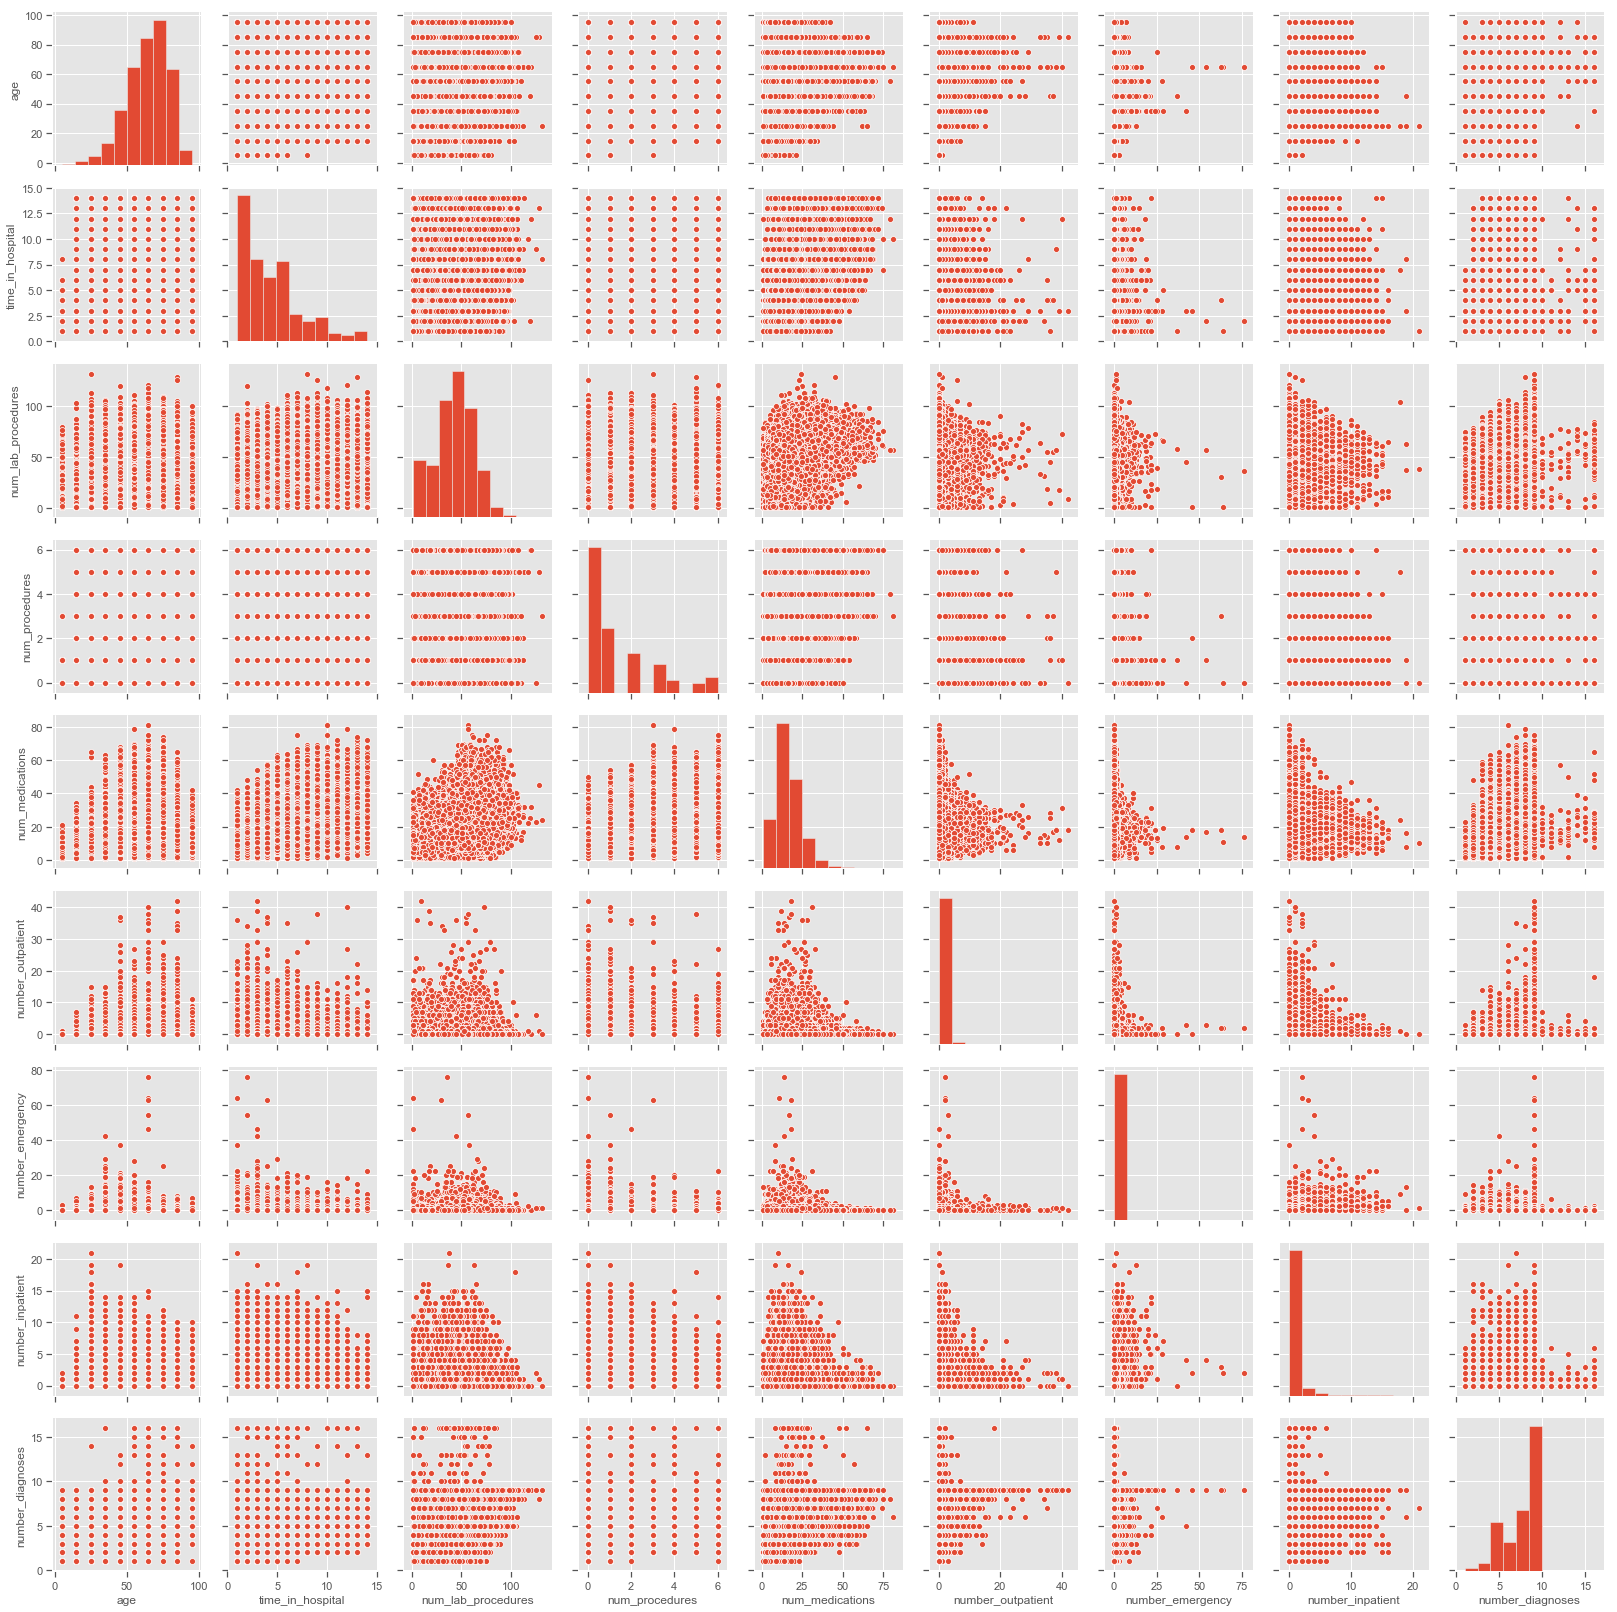

In [165]:
readmitsnumeric = get_num_cols(df).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)
sns.pairplot(readmitsnumeric, color='lightblue', hue='')
# plt.tight_layout()


In [158]:
# df = pd.get_dummies(df, drop_first=True)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94663 entries, 1 to 101765
Data columns (total 42 columns):
encounter_id                94663 non-null int64
patient_nbr                 94663 non-null int64
race                        92463 non-null object
gender                      94663 non-null object
age                         94663 non-null int64
admission_type_id           94663 non-null int64
discharge_disposition_id    94663 non-null int64
admission_source_id         94663 non-null int64
time_in_hospital            94663 non-null int64
num_lab_procedures          94663 non-null int64
num_procedures              94663 non-null int64
num_medications             94663 non-null int64
number_outpatient           94663 non-null int64
number_emergency            94663 non-null int64
number_inpatient            94663 non-null int64
number_diagnoses            94663 non-null int64
max_glu_serum               94663 non-null object
A1Cresult                   94663 non-null object
metf

In [39]:
df.to_csv('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/data/clean_df.csv')

## Exploratory Data Analysis

It is worth exploring if any of the numeric variables have any correlations. We will write a function to exract numeric columns from a data frame of choice and return a numeric data frame. This will be performed for both the 

Extraction of numeric columns and plotting in a pairplot did not yield any strong correlations. 

In [107]:
readmitsnumeric = get_num_cols(df).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)
# sns.pairplot(readmitsnumeric, hue='readmit_True')
# plt.tight_layout()
readmitsnumeric.head()


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,diabetesMed_Yes,readmit_True
1,15,3,59,0,18,0,0,0,9,0,...,1,1,0,0,0,0,0,0,1,0
2,25,2,11,5,13,2,0,1,6,0,...,0,1,0,0,0,0,0,0,1,0
3,35,2,44,1,16,0,0,0,7,0,...,1,1,0,0,0,0,0,0,1,0
4,45,1,51,0,8,0,0,0,5,0,...,0,1,0,0,0,0,0,0,1,0
5,55,3,31,6,16,0,0,0,9,0,...,0,1,0,0,0,0,0,0,1,0


In [40]:
dfnumeric = get_num_cols(df).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)

In [ ]:
# sns.pairplot(dfnumeric)
# plt.tight_layout()

The columns with integer values did not provide a lot of insight. These int columns are largely nominal and interval variables which explains their lack of fruitful information in the pairplots generated above. 

Let's further evaluate the distributions of these continuous variables to see if they have any predictive power in the classification. 

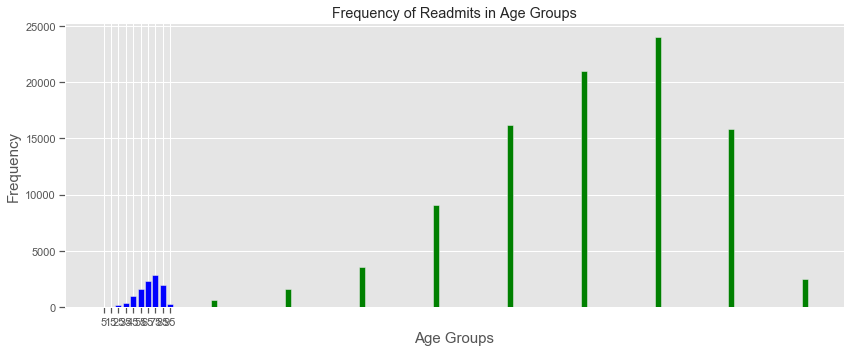

In [42]:
readmitsagedf = pd.DataFrame(readmitsdf.groupby(readmitsdf.age).size())
readmitsagedf = readmitsagedf.reset_index()
readmitsagedf.columns = ['age group', 'freq']

agedf = pd.DataFrame(df.groupby(df.age).size())
agedf = agedf.reset_index()
agedf.columns = ['age group', 'freq']

# fig,ax = plt.subplots(1, figsize=(12,5))
# ax.set_title('Frequency of Readmits in Age Groups')
# ax.bar(agedf['age group'], agedf.freq, color='green')
# ax.bar(readmitsagedf['age group'], readmitsagedf.freq, color='blue')
# ax.set_ylabel('Frequency',fontsize=15)
# ax.set_xlabel('Age Groups', fontsize=15)
# ax.set_xticks(range(len(agedf)))
# ax.set_xticklabels(agedf['age group'])
# plt.tight_layout()
# plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/readmitsbyage.png')

In [61]:
agedf.head()

,age group,freq
0,5,150
1,15,665
2,25,1595
3,35,3602
4,45,9114


In [67]:
# readmit = readmitsdf['age']
# nonreadmit = negdf['age']
# bins = np.linspace(-5,100, 10)
# plt.hist(readmit, bins, alpha=0.9, label='readmitted')
# plt.hist(nonreadmit, bins, alpha=0.3, label='not readmitted')
# plt.legend(loc='upper right')
# plt.yscale('symlog')
# plt.xlabel('Age')
# plt.ylabel('frequency')
# plt.title('Frequency of Age')
# plt.show()
# plt.savefig('img/readmitsbyage.png')

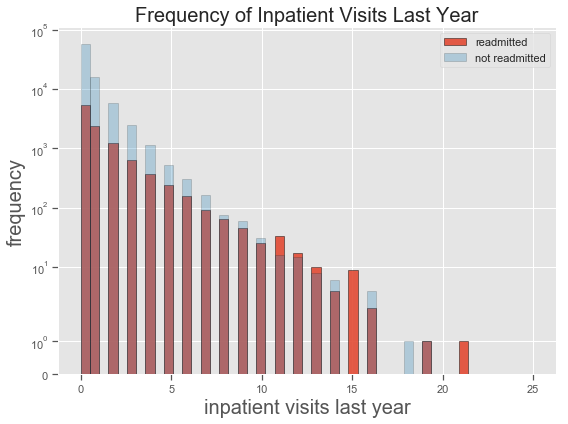

In [164]:
readmit = readmitsdf['number_inpatient']
nonreadmit = negdf['number_inpatient']
bins = np.linspace(0,25)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
plt.yscale('symlog')
plt.xlabel('inpatient visits last year', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of Inpatient Visits Last Year', fontsize=20)
plt.tight_layout()
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/inpatient_visits.png')

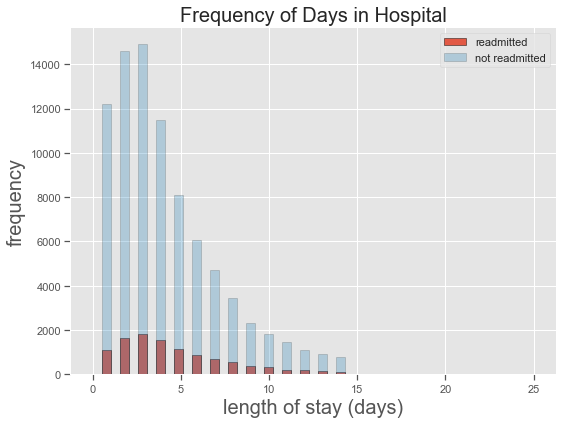

In [167]:
readmit = readmitsdf['time_in_hospital']
nonreadmit = negdf['time_in_hospital']
bins = np.linspace(0,25)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
# plt.yscale('symlog')
plt.xlabel('length of stay (days)',fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of Days in Hospital', fontsize=20)
plt.tight_layout()
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/hospital_days.png')

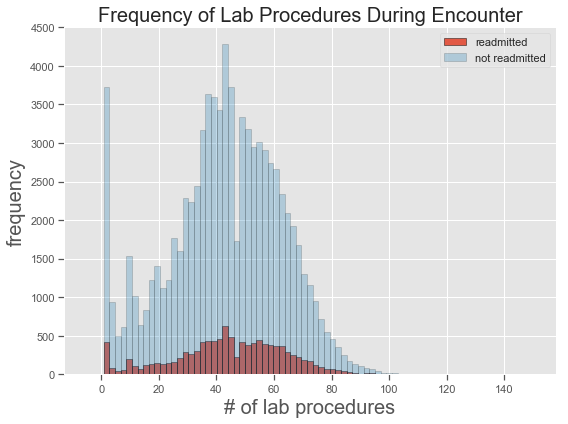

In [85]:
readmit = readmitsdf['num_lab_procedures']
nonreadmit = negdf['num_lab_procedures']
bins = np.linspace(-5,150,80)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
# plt.yscale('symlog')
plt.xlabel('# of lab procedures', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of Lab Procedures During Encounter', fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/lab_procedures.png')
plt.tight_layout()

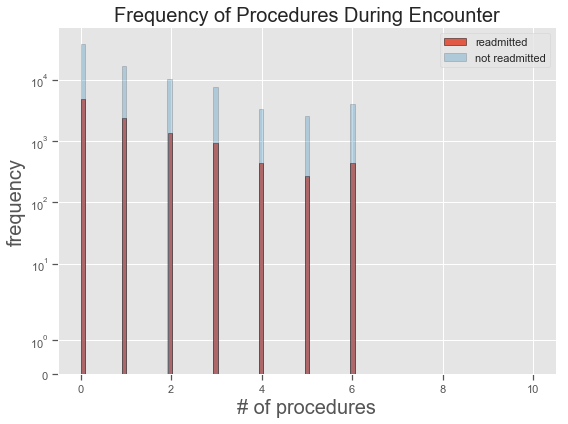

In [93]:
readmit = readmitsdf['num_procedures']
nonreadmit = negdf['num_procedures']
bins = np.linspace(0,10,100)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
plt.yscale('symlog')
plt.xlabel('# of procedures',fontsize=20)
plt.ylabel('frequency',fontsize=20)
plt.title('Frequency of Procedures During Encounter',fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/procedures.png')
plt.tight_layout()

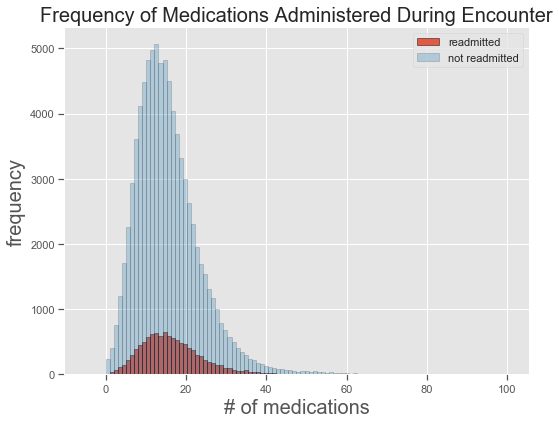

In [95]:
readmit = readmitsdf['num_medications']
nonreadmit = negdf['num_medications']
bins = np.linspace(-5,100, 105)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
# plt.yscale('symlog')
plt.xlabel('# of medications', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of Medications Administered During Encounter', fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/num_meds.png')
plt.tight_layout()

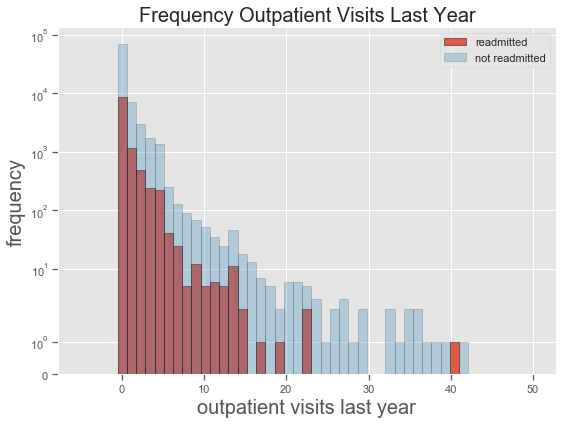

In [101]:
readmit = readmitsdf['number_outpatient']
nonreadmit = negdf['number_outpatient']
bins = np.linspace(-5,50,50)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
plt.yscale('symlog')
plt.xlabel('outpatient visits last year', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency Outpatient Visits Last Year', fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/outpatient.png')
plt.tight_layout()

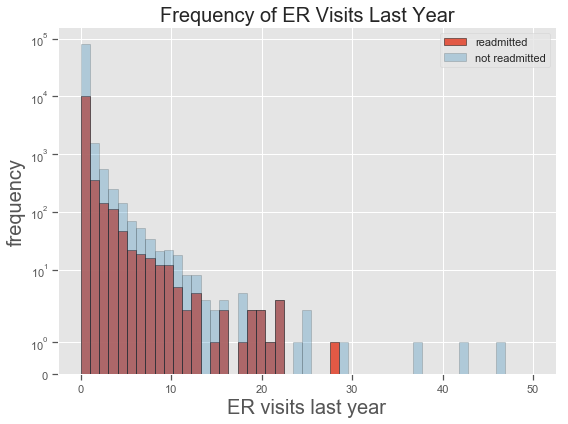

In [172]:
readmit = readmitsdf['number_emergency']
nonreadmit = negdf['number_emergency']
bins = np.linspace(0,50,50)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
plt.yscale('symlog')
plt.xlabel('ER visits last year', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of ER Visits Last Year', fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/ER.png')
plt.tight_layout()

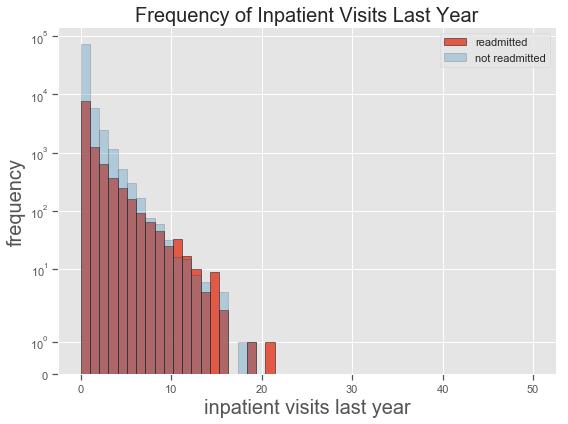

In [171]:
readmit = readmitsdf['number_inpatient']
nonreadmit = negdf['number_inpatient']
bins = np.linspace(0,50,50)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
plt.yscale('symlog')
plt.xlabel('inpatient visits last year', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of Inpatient Visits Last Year', fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/inpatient_visits.png')
plt.tight_layout()

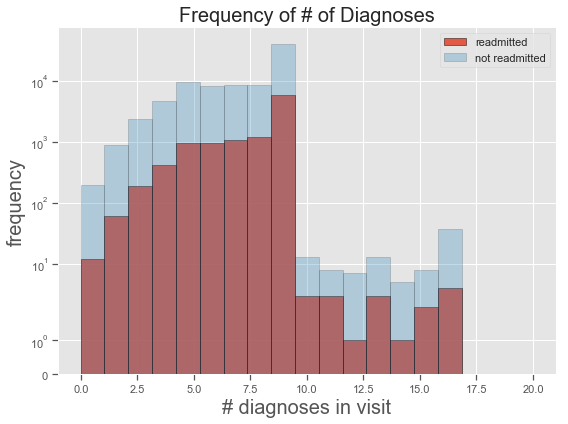

In [170]:
readmit = readmitsdf['number_diagnoses']
nonreadmit = negdf['number_diagnoses']
bins = np.linspace(0,20, 20)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(readmit, bins, alpha=0.9, label='readmitted', edgecolor='black')
ax.hist(nonreadmit, bins, alpha=0.3, label='not readmitted',edgecolor='black')
ax.legend(loc='upper right')
plt.yscale('symlog')
plt.xlabel('# diagnoses in visit', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Frequency of # of Diagnoses', fontsize=20)
plt.savefig('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/img/num_diagnoses.png')
plt.tight_layout()

In [75]:
# readmit = readmitsdf['age'].replace({'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, 
#                   '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95})
# nonreadmit = negdf['age'].replace({'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, 
#                   '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95})
# bins = np.linspace(-5,100,50)
# plt.hist(readmit, bins, alpha=0.9, label='readmitted')
# plt.hist(nonreadmit, bins, alpha=0.3, label='not readmitted')
# plt.legend(loc='upper right')
# # plt.yscale('symlog')
# plt.show()

In [76]:
# readmitsa1cdf = pd.DataFrame(readmitsdf.groupby(readmitsdf.A1Cresult).size())
# readmitsa1cdf = readmitsa1cdf.reset_index()
# readmitsa1cdf.columns = ['A1C groups', 'freq']
# readmitsa1cdf.head()
# a1cdf = pd.DataFrame(df.groupby(df.A1Cresult).size())
# a1cdf = a1cdf.reset_index()
# a1cdf.columns = ['A1C groups', 'freq']

# fig,ax = plt.subplots(1, figsize=(12,5))
# ax.set_title('Frequency of Readmits in A1C level Groups')
# ax.bar(a1cdf[~a1cdf['A1C groups'].isin([None])], a1cdf.freq, color='green')
# ax.bar(readmitsa1cdf[~readmitsa1cdf['A1C groups'].isin([None])], readmitsa1cdf.freq, color='blue')
# ax.set_ylabel('Frequency',fontsize=15)
# ax.set_xlabel('A1C Groups', fontsize=15)
# ax.set_xticks(range(len(a1cdf)))
# ax.set_xticklabels(a1cdf['A1C groups'])
# plt.tight_layout()


In [77]:
missing_data(df, 5)

[]

It would be interesting to evaluate patients that had more than one encounter to see if we can glean any more information from these individuals 

## Hypothesis Testing


Since the columns in this dataset are largely categorical variables, we want to test some of these for indepence. 

As there are various mechanisms of action by which diabetes medication can treat the disease, there are many medications on the market. This can be seen by the 23 various diabetes medications that are included in this data set. Finding the optimal medication for each patient can often be an exercise of trial and error. Adverse side-effects secondary to a medication change often result in hospitalization as patients need to be monitored with serial blood glucose tests. 

I'd like to test the change in medication column and the readmission column for independence. Since these both only contain two possible values, this would be a fairly straight forward X^2 test

#### State Null and Alternative Hypothesis

>$H_0$:Change in Medicine and Readmission are independent variables

>$H_A$:They are not independent

#### Assumptions

- When testing the data, the cells should be counts of cases and not percentages. It is okay to convert to percentages after testing the data
- The levels (groups) of the variables being tested are mutually exclusive
- Each participant contributes to only one cell within the Chi-square table
- The groups being tested must be independent
- The value of expected cells should be greater than 5 for at least 20% of the cells

Taken from [this](https://pythonfordatascience.org/chi-square-test-of-independence-python/) medium article

#### Assemble the Contingency Table

In [80]:
crosstab = pd.crosstab(df['change'],df['readmit'])
crosstab

readmit,False,True
change,,
False,44667,5388
True,39233,5375


#### Decide how Suprised You Need to Be to Reject Your Skeptical Assumption

Let's set the rejection threshold pretty stringently: $\alpha = 0.03$.

#### Compute the Test Statistic


The first step in the Chi Squared test is to compute the following test statistic:

$$ T = \sum_i \frac{(O_i - E_i)^2}{E_i} $$

In [81]:
stats.chi2_contingency(crosstab)

(38.53770127098957,
 5.370613641023194e-10,
 1,
 array([[44363.84331787,  5691.15668213],
        [39536.15668213,  5071.84331787]]))

The logic of the Chi Squared test is that this quantity follows a certain distribution, the chi squared distribution.

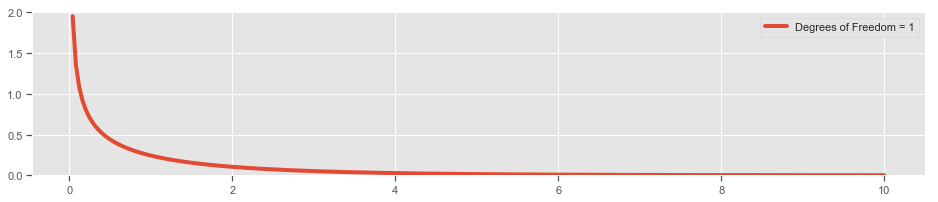

In [82]:
degfree = 1
x = np.linspace(0,10, num=250)

fig, ax = plt.subplots(1, figsize=(16,3))

chisq = stats.chi2(degfree)

ax.plot(x, chisq.pdf(x), linewidth=4,
       label = 'Degrees of Freedom = 1')
ax.set_ylim(0,2)
ax.legend()

The 2-way Chi squared test provides the degrees of freedom as:
    
$$ \text{(Number of rows - 1)} * \text{(Number of columns - 1)} $$

The plot above shows the PDF for a Chi-Square distribution with 1 degree of freedom

With a Chi Square test score of 39.02, we can appreciate a very small p-value as the test shows. 

In [83]:
table, results = rp.crosstab(df['change'],df['readmit'],prop='col', test='chi-square')
table

readmit                
         False    True     All
change                        
False    53.24   50.06   52.88
True     46.76   49.94   47.12
All     100.00  100.00  100.00

In [84]:
results

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,38.6651
1,p-value =,0.0000
2,Cramer's phi =,0.0202


Since we will be repeating this test for several variables, we will write a function

In [89]:
cat_cols = get_cat_cols(df)

In [92]:
chisq(cat_cols)

[['column_name', 'X^2_score', 'p-value', 'df'],
 ['race', 8.990685639101484, 0.061332717791619695, 4],
 ['gender', 0.5727291615170994, 0.7509887699750135, 2],
 ['max_glu_serum', 16.187941724113216, 0.0010376806240187278, 3],
 ['A1Cresult', 46.168682548864396, 5.22192103313535e-10, 3],
 ['metformin', 64.18172844952696, 7.50543148711194e-14, 3],
 ['repaglinide', 10.70605536229815, 0.013426316399857658, 3],
 ['nateglinide', 1.4177609360492096, 0.701376801273325, 3],
 ['chlorpropamide', 2.752475257183986, 0.4313832042589504, 3],
 ['glimepiride', 9.115001972377685, 0.027800310654517987, 3],
 ['acetohexamide', 1.4808926565523863, 0.22363491012275455, 1],
 ['glipizide', 10.798229180179343, 0.012868491279489858, 3],
 ['glyburide', 6.478330616403207, 0.09052101944499943, 3],
 ['tolbutamide', 0.37242170198732605, 0.5416871832479594, 1],
 ['pioglitazone', 10.981650066696593, 0.011825515552231257, 3],
 ['rosiglitazone', 6.916480855054773, 0.07460799498060645, 3],
 ['acarbose', 2.642326662572078, 0

#### Results

Based on these test results, we can reject the $H_0$ and conclude that hospital readmissions have a very weak dependence on changes in medicine. 

In [93]:
stats.chi2_contingency(crosstab)[:3]

(38.53770127098957, 5.370613641023194e-10, 1)